# Fast Fourier Transform Spectral Analysis

In [1]:
#Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from pynq import Xlnk
from pynq import Overlay
from ipywidgets import *

## Create the Pynq Overlay

Downloads the bitstream to the board, and parse the .tcl and .hwh files

In [2]:
ol = Overlay("design_1_wrapper.bit") # hwh is parsed here

## Initiate buffers and Contiguous Memory Access (CMA)

In [3]:
#initiate CMA
xlnk = Xlnk()

#define Buffers of size 256 and unsigned int 32 bits
input_buffer = xlnk.cma_array(shape=(256,), dtype=np.uint32)
output_buffer = xlnk.cma_array(shape=(256,), dtype=np.uint32)

## Frequency Select

Here a slider has been added to allow the user to choose their own frequency, this adds an interactive element to the code.

In [4]:
def update(freqDesired):
      freqDesired = freqDesired   # update the value for freqDesired
        
freqDesired = widgets.IntSlider(min=1000,max=20000000,step=1000)   #slider widget to display frequency selection
interact(update,freqDesired = freqDesired)   # update the freqDesired value

interactive(children=(IntSlider(value=1000, description='freqDesired', max=20000000, min=1000, step=1000), Out…

<function __main__.update>

In [5]:
freqDesired =int(freqDesired.value)   #Sets the value to an int based on the widgets last value

## Creating a signal from desired frequency

This section generates a signal with 256 bits in length, matching the size of the buffers, and at the selected frequency.

In [21]:
t = np.linspace(0, 2*np.pi, 256, endpoint=True) # define the period of signal
f = freqDesired   # Frequency in Hz
A = 100.0   # Amplitude in Unit
signal = A * np.sin(2*np.pi*f*t)   # Signal

## Creating Window function types

Creates a Hanning, Hamming & Blackman Widnow, for the length of the signal

In [22]:
hann = np.hanning(len(signal)) # define hanning function for length of signal
hamm = np.hamming(len(signal)) # define hamming function for length of signal
black= np.blackman(len(signal)) # define blackman function for length of signal

hannSignal = hann* signal # create hanning signal from original signal
hammSignal = hamm* signal # create hamming signal from original signal
blackSignal = black* signal # create blackman signal from original signal

A window function is an isolated part of a signal used to analyse the waveform. Theoretically When another waveform or function is multiplied by the window function, all the values outside the window range are also zero. This leaves a segment of the two parts overlapping within the initial range of the window. In reality the segment of data within the window range would be isolated first, then multiplying by the window function. This means that all the values outside the window range would not go to zero. The window functions that are used to analyse the data, are Hann Windows, Hamming Windows or Blackman Windows. Reference found at bottom [1].

### No Window

Text(0.5,1,'Signal with no window applied')

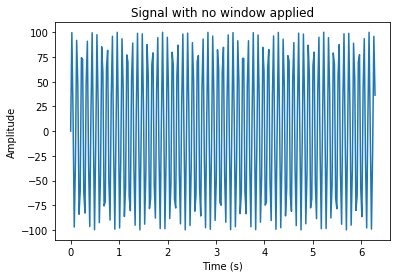

In [23]:
plt.plot(t,signal) # plot original signal
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Signal with no window applied')

### 1) Hanning Window

The Hann Window uses a cosine-sum window. For K=1 the below formula is used 

![](images/HANN.png)

Setting a0  = 0.5 produces a Hann Window. 
This is also known as a raised cosine, because at zero phase, ω0(n), is one lobe of an elevated 
cosine function. The Hann window is a member of both the cosine-sum and power-of-sine families. The end points of the Hann window roll of from the peak at around 18db per octave and touch zero at the end points. References found at bottom [2] & [3].


Text(0.5,1,'Signal with Hanning Window function applied')

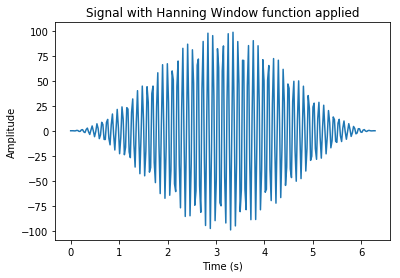

In [24]:
plt.plot(t,hannSignal) # plot hanning signal
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Signal with Hanning Window function applied')

### 2) Hamming Window

The Hamming window is similar to the Hann window. It uses the same equation for ω(n) but the Hamming Window sets a0 = 0.54 (25/46) which results in:

![](images/HAMM.png)

The Hamming Window, like the Hann Window is a sinusoidal shape, however, where they differ is that the Hamming Window’s roll-off does not reach zero inside the range of the window. This difference means the Hamming Window is better at cancelling the sidelobe nearest zero, but less effective at cancelling other sidelobes. References found at bottom [4] & [5].

Text(0.5,1,'Signal with Hamming Window function applied')

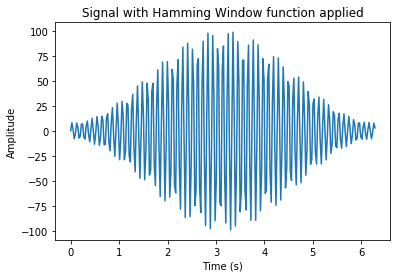

In [25]:
plt.plot(t,hammSignal) # plot hamming signal
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Signal with Hamming Window function applied')

### 3) Blackman Window

The Blackman Window function is defined by the equation: 

![](images/BLACK1.png)

This is Blackman’s proposal and results in the following equation: 

![](images/BLACK2.png)

The Blackman window is similar to the Hann and Hamming Window’s in that it is a sinusoidal shape with a peak that covers a lot of the area inside the window. However, the Blackman window has a higher roll-off rate towards zero. The Blackman Window, like the Hann Window reaches zero inside the range of the window. References found at bottom [6] & [7].


Text(0.5,1,'Signal with Blackman Window function applied')

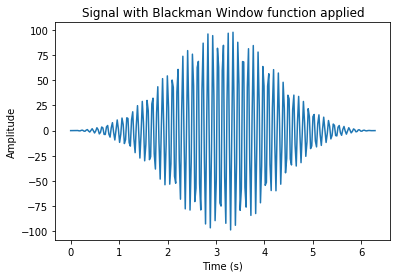

In [26]:
plt.plot(t,blackSignal) # plot blackman signal
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Signal with Blackman Window function applied')

## Select window to be applied to Signal

This section allows the user to select what window they would like to apply to the signal, prior to being processed by the FFT

In [27]:
assignedSignal = [] # create empty array to assign selected signal to
def sel(window):
    global assignedSignal
    
    # Window options for each possible drop down menu option
    if (window == 0):
        assignedSignal = signal 
    elif (window == 1):
        assignedSignal = hannSignal
    elif (window == 2):
        assignedSignal = hammSignal
    elif (window == 3):
        assignedSignal = blackSignal
    

interact(sel,window=[('No Window',0),('Hanning',1),('Hamming',2),('Blackman',3)]); # Drop down menu widget with 4 window options

interactive(children=(Dropdown(description='window', options=(('No Window', 0), ('Hanning', 1), ('Hamming', 2)…

# Fast Fourier Transform

A Fast Fourier Transform is a fast computational algorithm for the Discrete Fourier Transform (DFT). 
The basic concept of FFT is to take an array of time-domain waveform samples and produce an array of frequency-domain spectrum samples. The DFT function is often found to be too slow, so therefore the FFT is needed for the process to be practical. 
The DFT uses the following formula:

![](images/FFT.png)

The number of operations for the DFT can be determined by, N complex multiplications, and N-1 complex additions, or N2 operations for the DFT. The FFT can reduce this from N2 to Nlog2N. For smaller numbers this may not make a massive difference but for larger numbers the difference in speed between the DFT and the FFT is massive. For example, N = 5x106, the DFT would require 2.5x1013 operations to complete this while the FFT would only require 111.27x106 operations. If each operation took 1 US the DFT would take just over 289 days to complete, while the FFT would take just under 2 minutes (111 seconds). Reference found at bottom [8].

## Fill up the input buffer with the assigned signal

In [28]:
for i in range(256):
    input_buffer[i] = assignedSignal[i] # Fill input buffer array with the assigned signal

## Transfer the Input buffer to the Hardware FFT, and retrieve the Output buffer

In [29]:
#Initiate the data transfer to the input buffer, and recieve the Output buffer
ol.axi_dma.recvchannel.transfer(output_buffer) 

ol.axi_dma.sendchannel.transfer(input_buffer)

ol.axi_dma.sendchannel.wait()

ol.axi_dma.recvchannel.wait()

The output must be scaled back as the buffer has 31 fractional bits, so this has to be accounted for and 31 bit shifts back allow for the actual value to be interpreted. 'fftshift' also centres the peak.

In [30]:
scaledOutput = np.fft.fftshift(output_buffer*2**-31) # Scale and shift the contents of the output buffer array

# Creating The Plot

## Getting the right values

In this section of code the position of the highest value from the scaled output list is found which will then be used to make a correct x axis in units of frequency instead of plotting the magnitude against the number of values in the array(256).

In [31]:
magnitude=np.array(scaledOutput)

max_index = np.argmax(magnitude, axis=0)

maxval= np.amax(magnitude)

## Getting X and Y values

Here 2 arrays both size of 256 are created to be used as the X and Y vaues for the plot of magnitude against frequency.
Then the position of the highest magnitude value from the scaledOutput list is used in the frequency array to assign the value of desired frequency at the exact same position. 

In [32]:
#create empty array with size of 256
frequencies = [0] * 256 
magnitude = scaledOutput

#changes value of the array at the same position as the scaled output list to freqDesired
frequencies[max_index] = freqDesired
freq=np.array(frequencies)
n=0
magnitude[max_index]=maxval

#making the position number a value to use in loop
fd_position =max_index

## Creating the correct ranges

Next 2 loops are used to create a correct range of frequencys before and after the position of desired frequency so that the plot shows a spike at the correct position.

In [33]:
#first loop creates range of frequencies leading up to that position
while n < fd_position:
    freq[n]=freqDesired/fd_position*n
    n=n+1
    

#here is where n number in the array is checked to make sure it starts from the correct value in the next loop
value=256-fd_position

#add 1 to position so next loop does not change freqDesired value
n=fd_position+1

#second loop creates range of frequencies from the position until end of array(256)

while n > fd_position and n<256:
    freq[n]=freqDesired/fd_position*n
    n=n+1    

## Plotting the graph

In this section of code the plot is created showing magnitude against frequency. An annotation is also added showing the exact coordinates of the spike as this is not shown on the x axis of the plot.

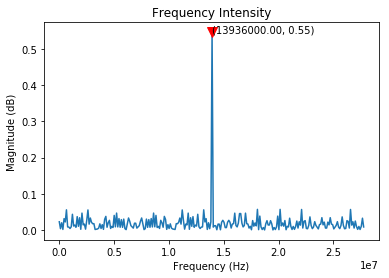

In [34]:
#plot is created
plt.plot(freq,magnitude)

plt.title("Frequency Intensity")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
#here an annotation is added to the peak as the x axis does not provide the specific value itself
x = freq[fd_position]
y = magnitude[fd_position]
plt.plot([x], [y], 'v', color='red', ms=10)
plt.text(x, y, "({:0.2f}, {:0.2f})".format(x, y))
plt.show()

# References

[1] https://download.ni.com/evaluation/pxi/Understanding%20FFTs%20and%20Windowing.pdf

[2] https://download.ni.com/evaluation/pxi/Understanding%20FFTs%20and%20Windowing.pdf

[3] https://uk.mathworks.com/help/signal/ref/hann.html

[4] https://download.ni.com/evaluation/pxi/Understanding%20FFTs%20and%20Windowing.pdf

[5] https://uk.mathworks.com/help/signal/ref/hamming.html

[6] https://download.ni.com/evaluation/pxi/Understanding%20FFTs%20and%20Windowing.pdf

[7] https://uk.mathworks.com/help/signal/ref/blackman.html

[8] https://www.dspguide.com/ch12/2.htm